# I prepared a dataset of hospital facilities Asthma dismissal records and uploaded it to Carto. 
## download it with an SQL query. Use the function I provide below.
## The name of the DB is NYCAsthmasDismissals
## *within the SQLquery* group the data by zipcode.

In [100]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import pylab as pl
import geopandas as gpd
import pandas as pd
%matplotlib inline

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [49]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
Select zipcodes, count(zipcodes)
FROM NYCAsthmasDismissals
Group by zipcodes
Limit 30
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.
# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [85]:
from geopandas import gpd
from fiona.crs import from_epsg
import shapely

shape_path="ZIP_CODE_040114.shp"
zip_shape = gpd.read_file(shape_path)


In [86]:
zip_shape.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [87]:
zip_shape = zip_shape[['ZIPCODE','geometry']]
zip_shape['center'] = zip_shape.geometry.centroid

In [88]:
zip_shape.head()

,ZIPCODE,geometry,center
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",POINT (1040696.262135346 185580.2219140405)
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",POINT (1001912.871996466 183803.1131420481)
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",POINT (1008365.375095716 180768.9448568909)
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",POINT (997023.1926918941 180870.3533200975)
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",POINT (990785.2911208535 173656.048379133)


In [89]:
facilities.zipcodes = facilities.zipcodes.astype(str)

In [90]:
merged = pd.merge(facilities, zip_shape, how='inner', left_on='zipcodes', right_on='ZIPCODE')

In [91]:
merged = merged[['count', 'zipcodes','center']]

In [92]:
merged.head()

,count,zipcodes,center
0,1699,10461,POINT (1028292.72437689 247902.4282787614)
1,405,11373,POINT (1017941.215480481 208485.1046661779)
2,1698,10451,POINT (1005358.961284301 238316.0675161843)
3,220,11691,POINT (1050360.772370908 158235.4624321515)
4,246,11375,POINT (1026858.206454871 201880.2234817908)


In [96]:
merged['x'] = [i.x for i in merged.center]
merged['y'] = [i.y for i in merged.center]

In [97]:
merged.head()

,count,zipcodes,center,x,y
0,1699,10461,POINT (1028292.72437689 247902.4282787614),1.028293e+06,247902.428279
1,405,11373,POINT (1017941.215480481 208485.1046661779),1.017941e+06,208485.104666
2,1698,10451,POINT (1005358.961284301 238316.0675161843),1.005359e+06,238316.067516
3,220,11691,POINT (1050360.772370908 158235.4624321515),1.050361e+06,158235.462432
4,246,11375,POINT (1026858.206454871 201880.2234817908),1.026858e+06,201880.223482


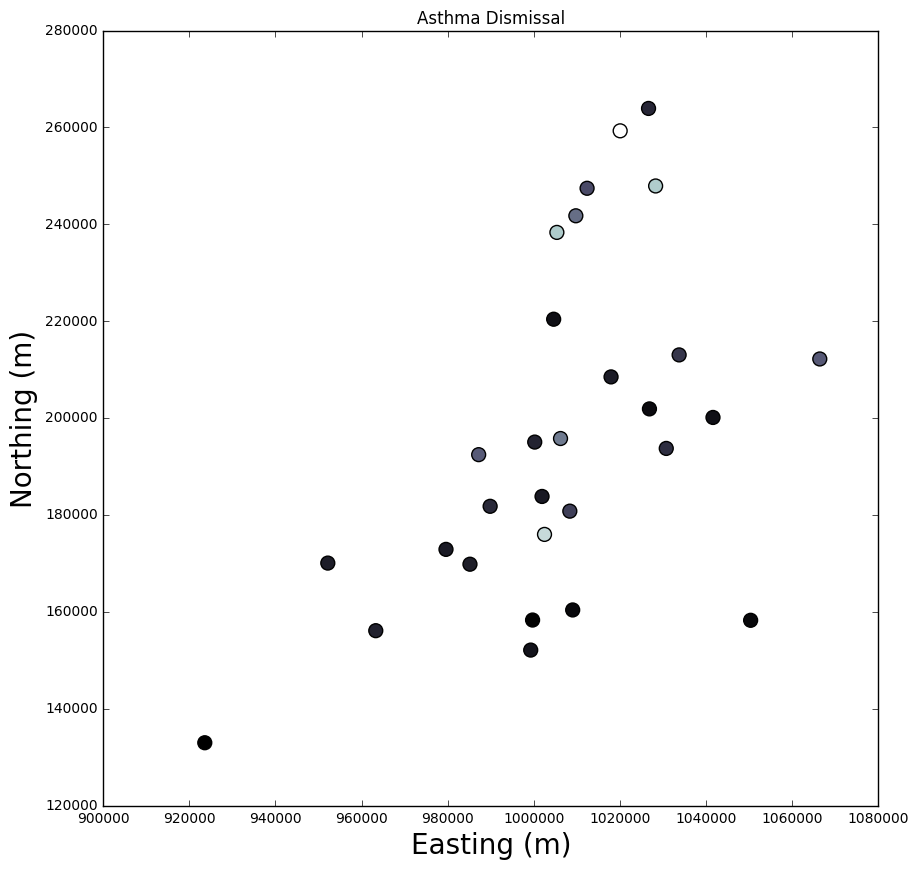

In [104]:
#plot the x and y coordinates for counts
ax = pl.figure(figsize=(10,10)).add_subplot(111)
ax.scatter(merged.x, merged.y, s=100, c = merged['count']/2.0, cmap='bone')
ax.set_xlabel('Easting (m)', fontsize=20)
ax.set_ylabel('Northing (m)', fontsize=20)
ax.set_title('Asthma Dismissal')

# Create and try to model the semi-variogram as we did in class
# https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
# Explain what is going on